In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

num_tissues = 3
num_samples = 10

readlen = 101

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# Here we need to implement a method for converting TPM information into
# coverage information for polyester
# we can do this by following the RSEM implementation of the TPM to number of reads conversion

# first load the distribution of the number of reads per sample
readlen_stats = pd.read_csv("/ccb/salz8-1/avaraby/tx_noise/data/readlen.stats",usecols=["readlen"])

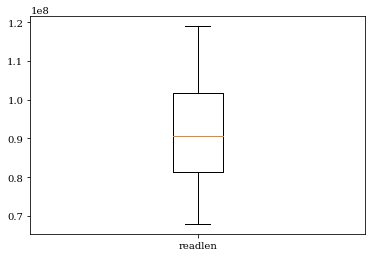

In [11]:
for label in readlen_stats.columns:
    # now we shall remove any outliers from the data
    q25,q50,q75 = readlen_stats[label].quantile([0.25,0.5,0.75])
    iqr = q75-q25
    thw = q75+0.5*iqr
    tlw = q25-0.5*iqr
    ahw = readlen_stats[readlen_stats[label]<=thw][label].max()
    alw = readlen_stats[readlen_stats[label]>=tlw][label].min()
    readlen_stats = readlen_stats[(readlen_stats[label]<=ahw)&(readlen_stats[label]>=alw)].reset_index(drop=True)

fig,ax = plt.subplots()
ax.boxplot(readlen_stats.T,labels=readlen_stats.T.index.tolist())
plt.show()

In [13]:
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    for sample_num in range(num_samples):
        print("++++++\n>Sample #"+str(sample_num)+"\n++++++\n")
        total_nreads = np.random.normal(readlen_stats["readlen"].mean(),readlen_stats["readlen"].std())
        print("number of reads in sample is: "+str(total_nreads))

        real = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        real["gid"] = real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        realt = real[real["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        reale = real[real["type"]=="exon"].reset_index(drop=True)
        reale["elen"] = reale["end"]-reale["start"]
        reale = reale[["tid","elen"]]
        reale = reale.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(realt["tid"])==set(reale["tid"]),"number of transcripts is not the same as number of groupped exons"
        reale = realt.merge(reale,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(reale),"number of tpms different from the number of transcripts"
        reale["tpm"] = tpms["tpm"]

        splicing = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        splicingt = splicing[splicing["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        splicinge = splicing[splicing["type"]=="exon"].reset_index(drop=True)
        splicinge["elen"] = splicinge["end"]-splicinge["start"]
        splicinge = splicinge[["tid","elen"]]
        splicinge = splicinge.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(splicingt["tid"])==set(splicinge["tid"]),"number of transcripts is not the same as number of groupped exons"
        splicinge = splicingt.merge(splicinge,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(splicinge),"number of tpms different from the number of transcripts"
        splicinge["tpm"] = tpms["tpm"]

        intronic = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        intronict = intronic[intronic["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        intronice = intronic[intronic["type"]=="exon"].reset_index(drop=True)
        intronice["elen"] = intronice["end"]-intronice["start"]
        intronice = intronice[["tid","elen"]]
        intronice = intronice.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(intronict["tid"])==set(intronice["tid"]),"number of transcripts is not the same as number of groupped exons"
        intronice = intronict.merge(intronice,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(intronice),"number of tpms different from the number of transcripts"
        intronice["tpm"] = tpms["tpm"]

        pol = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        pol["tid"] = pol["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        pol["gid"] = pol["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        polt = pol[pol["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        pole = pol[pol["type"]=="exon"].reset_index(drop=True)
        pole["elen"] = pole["end"]-pole["start"]
        pole = pole[["tid","elen"]]
        pole = pole.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(polt["tid"])==set(pole["tid"]),"number of transcripts is not the same as number of groupped exons"
        pole = polt.merge(pole,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(pole),"number of tpms different from the number of transcripts"
        pole["tpm"] = tpms["tpm"]
        
        joined = pd.concat([reale[["tid","elen","tpm"]],splicinge[["tid","elen","tpm"]],intronice[["tid","elen","tpm"]],pole[["tid","elen","tpm"]]],axis=0).reset_index(drop=True)
        joined["theta"] = joined["elen"]*joined["tpm"]
        denom = joined["theta"].sum()
        joined["cor"] = joined["theta"]/denom
        # now that we have all these values, we 
        joined["cov"] = (joined["cor"]*total_nreads*readlen)/joined["elen"]
        # now we can merge the data to comply with the original ordering
        # and proceed to write it out
        realt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",index=False,header=False)
        splicingt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",index=False,header=False)
        intronict.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",index=False,header=False)
        polt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",index=False,header=False)


Tissue #0

++++++
>Sample #0
++++++

number of reads in sample is: 73823384.99041033
++++++
>Sample #1
++++++

number of reads in sample is: 85105738.84843396
++++++
>Sample #2
++++++

number of reads in sample is: 116548929.3445094
++++++
>Sample #3
++++++

number of reads in sample is: 89638996.16990443
++++++
>Sample #4
++++++

number of reads in sample is: 82413511.93373978
++++++
>Sample #5
++++++

number of reads in sample is: 82644467.15347973
++++++
>Sample #6
++++++

number of reads in sample is: 111124938.56628963
++++++
>Sample #7
++++++

number of reads in sample is: 97192405.64986117
++++++
>Sample #8
++++++

number of reads in sample is: 93652790.65603974
++++++
>Sample #9
++++++

number of reads in sample is: 62826802.96979342

Tissue #1

++++++
>Sample #0
++++++

number of reads in sample is: 98234773.85894907
++++++
>Sample #1
++++++

number of reads in sample is: 87373858.3069808
++++++
>Sample #2
++++++

number of reads in sample is: 95882169.57037285
++++++
>Sample

In [32]:
# now we can also compute TPMs for each sample
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    for sample_num in range(num_samples):
        print("++++++\n>Sample #"+str(sample_num)+"\n++++++\n")
        real = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        real["gid"] = real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        realt = real[real["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        reale = real[real["type"]=="exon"].reset_index(drop=True)
        reale["elen"] = reale["end"]-reale["start"]
        reale = reale[["tid","elen"]]
        reale = reale.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(realt["tid"])==set(reale["tid"]),"number of transcripts is not the same as number of groupped exons"
        reale = realt.merge(reale,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(reale),"number of tpms different from the number of transcripts"
        reale["tpm"] = tpms["tpm"]
        covs = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",names=["cov"])
        assert len(covs)==len(reale),"number of covs different from the number of transcripts"
        reale["cov"] = covs["cov"]

        splicing = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        splicingt = splicing[splicing["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        splicinge = splicing[splicing["type"]=="exon"].reset_index(drop=True)
        splicinge["elen"] = splicinge["end"]-splicinge["start"]
        splicinge = splicinge[["tid","elen"]]
        splicinge = splicinge.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(splicingt["tid"])==set(splicinge["tid"]),"number of transcripts is not the same as number of groupped exons"
        splicinge = splicingt.merge(splicinge,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(splicinge),"number of tpms different from the number of transcripts"
        splicinge["tpm"] = tpms["tpm"]
        covs = pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",names=["cov"])
        assert len(covs)==len(splicinge),"number of covs different from the number of transcripts"
        splicinge["cov"] = covs["cov"]

        intronic = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        intronict = intronic[intronic["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        intronice = intronic[intronic["type"]=="exon"].reset_index(drop=True)
        intronice["elen"] = intronice["end"]-intronice["start"]
        intronice = intronice[["tid","elen"]]
        intronice = intronice.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(intronict["tid"])==set(intronice["tid"]),"number of transcripts is not the same as number of groupped exons"
        intronice = intronict.merge(intronice,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(intronice),"number of tpms different from the number of transcripts"
        intronice["tpm"] = tpms["tpm"]
        covs = pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",names=["cov"])
        assert len(covs)==len(intronice),"number of covs different from the number of transcripts"
        intronice["cov"] = covs["cov"]

        pol = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols)
        pol["tid"] = pol["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        pol["gid"] = pol["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
        polt = pol[pol["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
        pole = pol[pol["type"]=="exon"].reset_index(drop=True)
        pole["elen"] = pole["end"]-pole["start"]
        pole = pole[["tid","elen"]]
        pole = pole.groupby("tid").agg({"elen":"sum"}).reset_index()
        assert set(polt["tid"])==set(pole["tid"]),"number of transcripts is not the same as number of groupped exons"
        pole = polt.merge(pole,how="left",on="tid")
        tpms = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",names=["tpm"])
        assert len(tpms)==len(pole),"number of tpms different from the number of transcripts"
        pole["tpm"] = tpms["tpm"]
        covs = pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".cov",names=["cov"])
        assert len(covs)==len(pole),"number of covs different from the number of transcripts"
        pole["cov"] = covs["cov"]

        joined = pd.concat([reale[["tid","elen","tpm","cov"]],\
                            splicinge[["tid","elen","tpm","cov"]],\
                            intronice[["tid","elen","tpm","cov"]],\
                            pole[["tid","elen","tpm","cov"]]],axis=0).reset_index(drop=True)
        joined["new_tpm"]=(joined["cov"]*1000000)/joined["cov"].sum()
        realt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        splicingt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        intronict.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        polt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)


Tissue #0

++++++
>Sample #0
++++++

++++++
>Sample #1
++++++

++++++
>Sample #2
++++++

++++++
>Sample #3
++++++

++++++
>Sample #4
++++++

++++++
>Sample #5
++++++

++++++
>Sample #6
++++++

++++++
>Sample #7
++++++

++++++
>Sample #8
++++++

++++++
>Sample #9
++++++


Tissue #1

++++++
>Sample #0
++++++

++++++
>Sample #1
++++++

++++++
>Sample #2
++++++

++++++
>Sample #3
++++++

++++++
>Sample #4
++++++

++++++
>Sample #5
++++++

++++++
>Sample #6
++++++

++++++
>Sample #7
++++++

++++++
>Sample #8
++++++

++++++
>Sample #9
++++++


Tissue #2

++++++
>Sample #0
++++++

++++++
>Sample #1
++++++

++++++
>Sample #2
++++++

++++++
>Sample #3
++++++

++++++
>Sample #4
++++++

++++++
>Sample #5
++++++

++++++
>Sample #6
++++++

++++++
>Sample #7
++++++

++++++
>Sample #8
++++++

++++++
>Sample #9
++++++



In [7]:
# let's now take one sample
# convert the coverages back to TPM
# scatterplot original TPM vs the obtained TPM
# there might be some differences, but should follow the same pattern largely
real = pd.read_csv(out_dir+"real.t0_s0.gtf",sep="\t",names=gff3cols)
real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
real["gid"] = real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
realt = real[real["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
reale = real[real["type"]=="exon"].reset_index(drop=True)
reale["elen"] = reale["end"]-reale["start"]
reale = reale[["tid","elen"]]
reale = reale.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(realt["tid"])==set(reale["tid"]),"number of transcripts is not the same as number of groupped exons"
reale = realt.merge(reale,how="left",on="tid")
tpms = pd.read_csv(out_dir+"real.t0_s0.exp",names=["tpm"])
assert len(tpms)==len(reale),"number of tpms different from the number of transcripts"
reale["tpm"] = tpms["tpm"]
covs = pd.read_csv(out_dir+"real.t0_s0.cov",names=["cov"])
assert len(covs)==len(reale),"number of covs different from the number of transcripts"
reale["cov"] = covs["cov"]

splicing = pd.read_csv(out_dir+"splicing.t0_s0.gtf",sep="\t",names=gff3cols)
splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
splicingt = splicing[splicing["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
splicinge = splicing[splicing["type"]=="exon"].reset_index(drop=True)
splicinge["elen"] = splicinge["end"]-splicinge["start"]
splicinge = splicinge[["tid","elen"]]
splicinge = splicinge.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(splicingt["tid"])==set(splicinge["tid"]),"number of transcripts is not the same as number of groupped exons"
splicinge = splicingt.merge(splicinge,how="left",on="tid")
tpms = pd.read_csv(out_dir+"splicing.t0_s0.exp",names=["tpm"])
assert len(tpms)==len(splicinge),"number of tpms different from the number of transcripts"
splicinge["tpm"] = tpms["tpm"]
covs = pd.read_csv(out_dir+"splicing.t0_s0.cov",names=["cov"])
assert len(covs)==len(splicinge),"number of covs different from the number of transcripts"
splicinge["cov"] = covs["cov"]

intronic = pd.read_csv(out_dir+"intronic.t0_s0.gtf",sep="\t",names=gff3cols)
intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
intronict = intronic[intronic["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
intronice = intronic[intronic["type"]=="exon"].reset_index(drop=True)
intronice["elen"] = intronice["end"]-intronice["start"]
intronice = intronice[["tid","elen"]]
intronice = intronice.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(intronict["tid"])==set(intronice["tid"]),"number of transcripts is not the same as number of groupped exons"
intronice = intronict.merge(intronice,how="left",on="tid")
tpms = pd.read_csv(out_dir+"intronic.t0_s0.exp",names=["tpm"])
assert len(tpms)==len(intronice),"number of tpms different from the number of transcripts"
intronice["tpm"] = tpms["tpm"]
covs = pd.read_csv(out_dir+"intronic.t0_s0.cov",names=["cov"])
assert len(covs)==len(intronice),"number of covs different from the number of transcripts"
intronice["cov"] = covs["cov"]

pol = pd.read_csv(out_dir+"intergenic.t0_s0.gtf",sep="\t",names=gff3cols)
pol["tid"] = pol["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
pol["gid"] = pol["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
polt = pol[pol["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
pole = pol[pol["type"]=="exon"].reset_index(drop=True)
pole["elen"] = pole["end"]-pole["start"]
pole = pole[["tid","elen"]]
pole = pole.groupby("tid").agg({"elen":"sum"}).reset_index()
assert set(polt["tid"])==set(pole["tid"]),"number of transcripts is not the same as number of groupped exons"
pole = polt.merge(pole,how="left",on="tid")
tpms = pd.read_csv(out_dir+"intergenic.t0_s0.exp",names=["tpm"])
assert len(tpms)==len(pole),"number of tpms different from the number of transcripts"
pole["tpm"] = tpms["tpm"]
covs = pd.read_csv(out_dir+"intergenic.t0_s0.cov",names=["cov"])
assert len(covs)==len(pole),"number of covs different from the number of transcripts"
pole["cov"] = covs["cov"]

joined = pd.concat([reale[["tid","elen","tpm","cov"]],\
                    splicinge[["tid","elen","tpm","cov"]],\
                    intronice[["tid","elen","tpm","cov"]],\
                    pole[["tid","elen","tpm","cov"]]],axis=0).reset_index(drop=True)
joined["new_tpm"]=(joined["cov"]*1000000)/joined["cov"].sum()
realt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        splicingt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        intronict.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)
        polt.merge(joined[["tid","new_tpm"]],how="left",on="tid")[["new_tpm"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".tpm",index=False,header=False)

,tid,elen,tpm,cov
0,CHS.3.2,3252,0.25,1.655020
1,CHS.39.13,2540,8.12,53.755053
2,CHS.39.22,461,2.40,15.888193
3,CHS.46.9,872,53.02,350.996662
4,CHS.12.1,3788,7.50,49.650603


In [31]:
joined["nr"] = (joined["cov"]*joined["elen"])/readlen
joined.head()

,tid,elen,tpm,cov,nr,rpk,new_tpm,ratio,strg_tpm
0,CHS.3.2,3252,0.25,1.655020,53.288370,8.193169,0.598069,2.392275,0.598069
1,CHS.39.13,2540,8.12,53.755053,1351.859742,266.114122,19.425272,2.392275,19.425272
2,CHS.39.22,461,2.40,15.888193,72.519376,78.654420,5.741460,2.392275,5.741460
3,CHS.46.9,872,53.02,350.996662,3030.387023,1737.607238,126.838415,2.392275,126.838415
4,CHS.12.1,3788,7.50,49.650603,1862.143404,245.795064,17.942062,2.392275,17.942062


In [28]:
joined["rpk"] = joined["nr"]/(joined["elen"]/1000)
joined.head()

,tid,elen,tpm,cov,nr,rpk,new_tpm,ratio,strg_tpm
0,CHS.3.2,3252,0.25,1.655020,26.644185,8.193169,0.598069,2.392275,0.598069
1,CHS.39.13,2540,8.12,53.755053,675.929871,266.114122,19.425272,2.392275,19.425272
2,CHS.39.22,461,2.40,15.888193,36.259688,78.654420,5.741460,2.392275,5.741460
3,CHS.46.9,872,53.02,350.996662,1515.193512,1737.607238,126.838415,2.392275,126.838415
4,CHS.12.1,3788,7.50,49.650603,931.071702,245.795064,17.942062,2.392275,17.942062


In [29]:
pmf = joined["rpk"].sum()/1000000
pmf

13.699376741338735

In [30]:
joined["new_tpm"]=joined["rpk"]/pmf
joined.head()

,tid,elen,tpm,cov,nr,rpk,new_tpm,ratio,strg_tpm
0,CHS.3.2,3252,0.25,1.655020,26.644185,8.193169,0.598069,2.392275,0.598069
1,CHS.39.13,2540,8.12,53.755053,675.929871,266.114122,19.425272,2.392275,19.425272
2,CHS.39.22,461,2.40,15.888193,36.259688,78.654420,5.741460,2.392275,5.741460
3,CHS.46.9,872,53.02,350.996662,1515.193512,1737.607238,126.838415,2.392275,126.838415
4,CHS.12.1,3788,7.50,49.650603,931.071702,245.795064,17.942062,2.392275,17.942062


In [26]:
joined["strg_tpm"]=(joined["cov"]*1000000)/joined["cov"].sum()
joined.head()

,tid,elen,tpm,cov,nr,rpk,new_tpm,ratio,strg_tpm
0,CHS.3.2,3252,0.25,1.655020,53.288370,16.386338,0.598069,2.392275,0.598069
1,CHS.39.13,2540,8.12,53.755053,1351.859742,532.228245,19.425272,2.392275,19.425272
2,CHS.39.22,461,2.40,15.888193,72.519376,157.308841,5.741460,2.392275,5.741460
3,CHS.46.9,872,53.02,350.996662,3030.387023,3475.214476,126.838415,2.392275,126.838415
4,CHS.12.1,3788,7.50,49.650603,1862.143404,491.590128,17.942062,2.392275,17.942062


In [25]:
joined["ratio"] = joined["new_tpm"]/joined["tpm"]
print(set(joined["ratio"]))
joined

{nan, nan, 2.392274904155898, 2.3922749041558973, 2.3922749041558986, 2.3922749041558977, 2.392274904155899, 2.3922749041558995, 2.392274904155897, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 2.3922749041559, 2.3922749041558964}


,tid,elen,tpm,cov,nr,rpk,new_tpm,ratio
0,CHS.3.2,3252,0.25,1.655020,53.288370,16.386338,0.598069,2.392275
1,CHS.39.13,2540,8.12,53.755053,1351.859742,532.228245,19.425272,2.392275
2,CHS.39.22,461,2.40,15.888193,72.519376,157.308841,5.741460,2.392275
3,CHS.46.9,872,53.02,350.996662,3030.387023,3475.214476,126.838415,2.392275
4,CHS.12.1,3788,7.50,49.650603,1862.143404,491.590128,17.942062,2.392275
...,...,...,...,...,...,...,...,...
41563,ALL_30460985,229,1.11,7.348289,16.660973,72.755339,2.655425,2.392275
41564,ALL_30466440,254,0.33,2.184627,5.494011,21.629966,0.789451,2.392275
41565,ALL_30404134,160,0.41,2.714233,4.299775,26.873594,0.980833,2.392275
41566,ALL_30440285,251,0.95,6.289076,15.629289,62.268083,2.272661,2.392275


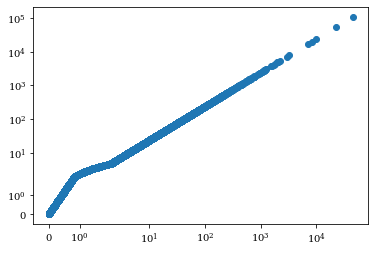

In [16]:
plt.scatter(joined["tpm"],joined["new_tpm"])
plt.yscale("symlog")
plt.xscale("symlog")

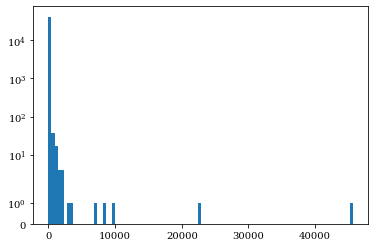

In [20]:
plt.hist(joined["tpm"],bins=100)
plt.yscale("symlog")

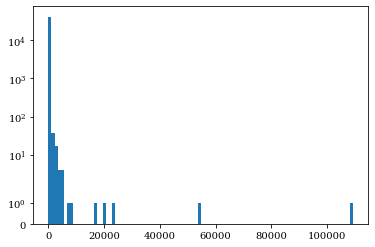

In [21]:
plt.hist(joined["new_tpm"],bins=100)
plt.yscale("symlog")